# Installation

In [ ]:
!pip install pmdarima

In [ ]:
!pip install pyramid

In [ ]:
!pip3 install statsmodels

In [4]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from random import random
from numpy import array
from numpy import cumsum

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#load dataset
AAPL = pd.read_csv("/content/drive/MyDrive/Datasets/AAPL.csv")

# Model

In [7]:
def Dataset(Data, Date):

  Train_Data = Data['Adj Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

In [8]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [9]:
model = Model()

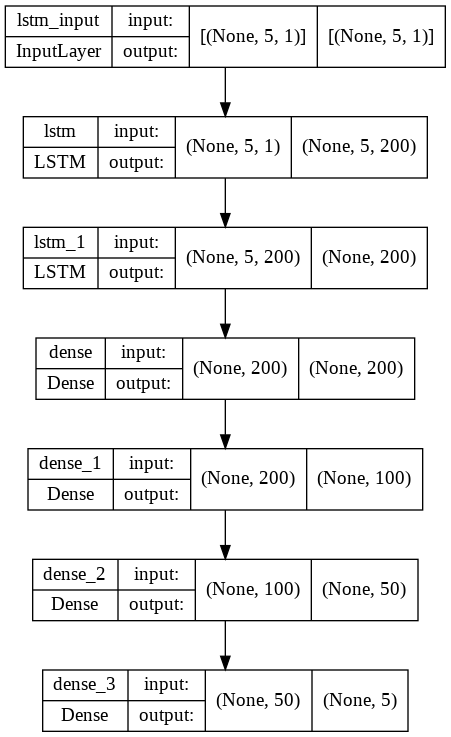

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548,005
Trainable params: 548,005
Non-trai

In [12]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

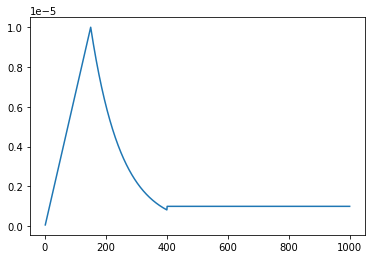

In [13]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [14]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Apple

In [15]:
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

In [16]:
AAPL_Date = '2021-12-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

In [17]:
AAPL_Model = Model()

In [18]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.1)
#optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

AAPL_Model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [20]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 500, batch_size = 32, verbose = 2, shuffle = False, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/500
8/8 - 1s - loss: 11.5226 - root_mean_squared_error: 3.3945 - val_loss: 39.5136 - val_root_mean_squared_error: 6.2860 - lr: 0.0000e+00 - 604ms/epoch - 75ms/step
Epoch 2/500
8/8 - 0s - loss: 11.5241 - root_mean_squared_error: 3.3947 - val_loss: 39.5114 - val_root_mean_squared_error: 6.2858 - lr: 6.6667e-08 - 459ms/epoch - 57ms/step
Epoch 3/500
8/8 - 1s - loss: 11.5253 - root_mean_squared_error: 3.3949 - val_loss: 39.5074 - val_root_mean_squared_error: 6.2855 - lr: 1.3333e-07 - 520ms/epoch - 65ms/step
Epoch 4/500
8/8 - 0s - loss: 11.5260 - root_mean_squared_error: 3.3950 - val_loss: 39.5025 - val_root_mean_squared_error: 6.2851 - lr: 2.0000e-07 - 457ms/epoch - 57ms/step
Epoch 5/500
8/8 - 0s - loss: 11.5265 - root_mean_squared_error: 3.3951 - val_loss: 39.4978 - val_root_mean_squared_error: 6.2847 - lr: 2.6667e-07 - 493ms/epoch - 62ms/step
Epoch 6/500
8/8 - 1s - loss: 11.5268 - root_mean_squared_error: 3.3951 - val_loss: 39.4937 - val_root_mean_squared_error: 6.2844 - lr: 3.333

In [21]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

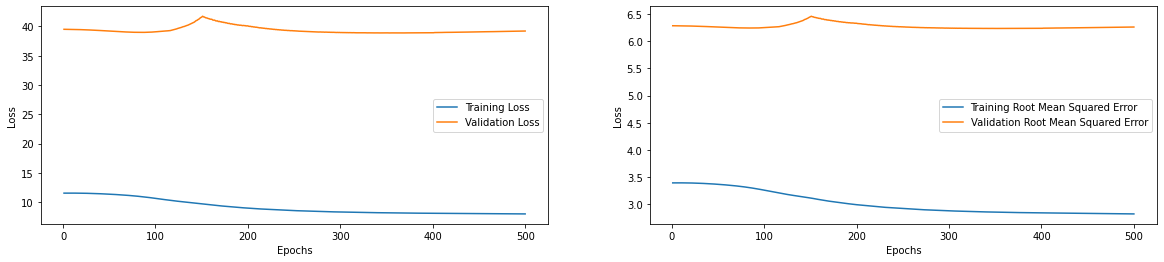

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(4)
fig.set_figwidth(20)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [23]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

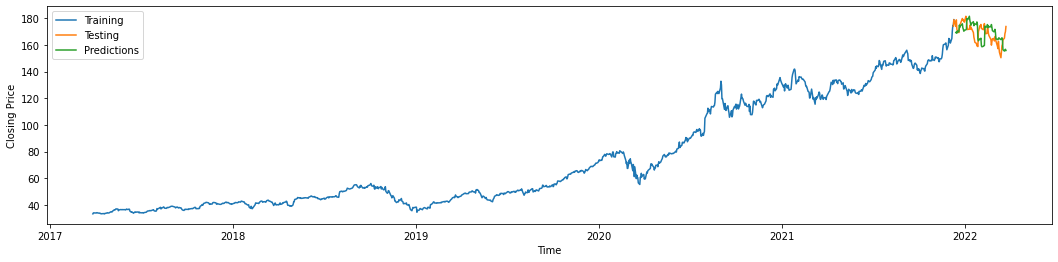

In [24]:
plt.figure(figsize=(18, 4))
plt.plot(AAPL['Date'][AAPL['Date'] < '2021-12-12'], AAPL['Adj Close'][AAPL['Date'] < '2021-12-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2021-12-09'], AAPL['Adj Close'][AAPL['Date'] >= '2021-12-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2021-12-14'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [25]:
MSE_error = mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction)
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))

print(f'MSE: {MSE_error}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MSE: 39.21772421007014
RMSE: 6.262405624843391
MAPE: 0.02989872018477023
